## 1.数据清洗

In [1]:
# 记得数据下载先保存编码为utf-8，数据来自 https://www.kaggle.com/vijayuv/onlineretail 
import pandas as pd, numpy as np
from datetime import datetime, date
from matplotlib import pyplot as plt
import seaborn as sns
df = pd.read_csv('OnlineRetail_utf-8.csv')
len(df)

541909

In [2]:
df.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
323897,565378,22666,RECIPE BOX PANTRY YELLOW DESIGN,10,9/2/2011 15:16,6.63,NaN,United Kingdom
126675,547094,22993,SET OF 4 PANTRY JELLY MOULDS,24,3/21/2011 8:39,1.25,13934.0,United Kingdom
154757,549943,37340,MULTICOLOUR SPRING FLOWER MUG,6,4/13/2011 12:09,0.39,13544.0,United Kingdom
238620,557950,84711B,PINK OVAL SHAPE TRINKET BOX,1,6/23/2011 17:35,9.95,17848.0,United Kingdom
77836,542789,22255,FELT TOADSTOOL SMALL,48,2/1/2011 10:38,0.85,17511.0,United Kingdom
141814,548522,22089,PAPER BUNTING VINTAGE PAISLEY,3,3/31/2011 16:43,5.79,NaN,United Kingdom
266244,560248,22960,JAM MAKING SET WITH JARS,2,7/17/2011 12:24,4.25,16255.0,United Kingdom
456886,575726,84879,ASSORTED COLOUR BIRD ORNAMENT,8,11/10/2011 19:12,1.69,16791.0,United Kingdom
215554,555722,84596L,BISCUITS SMALL BOWL LIGHT BLUE,2,6/6/2011 16:06,0.83,NaN,United Kingdom
145747,548898,72802B,OCEAN SCENT CANDLE IN JEWELLED BOX,2,4/4/2011 16:28,4.25,17214.0,United Kingdom


In [3]:
# 负数异常数据剔除
df = df[(df.Quantity > 0) & (df.UnitPrice > 0)]

In [4]:
# 查看同一股票代码的不同产品描述有多少种
df.groupby('StockCode').Description.nunique().sort_values(ascending=False)

StockCode
23236     4
23196     4
17107D    3
22776     3
23366     3
         ..
46776B    1
46776A    1
46775D    1
46138B    1
10002     1
Name: Description, Length: 3922, dtype: int64

In [5]:
# 剔除异常产品数据
df = df[~df.StockCode.isin(['POST', 'DOT', 'M', 'AMAZONFEE', 'BANK CHARGES', 'C2', 'S'])]
len(df)

527794

In [6]:
# 清洗控制变量
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate)
df['Date'] = pd.to_datetime(df.InvoiceDate.dt.date)
df['revenue'] = df.Quantity * df.UnitPrice

<AxesSubplot:title={'center':'number of items sold and number of orders over time'}, xlabel='Date'>

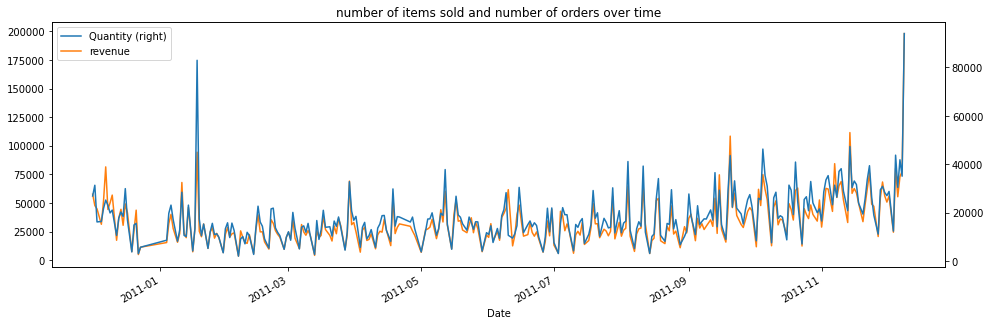

In [7]:
# 查看数据趋势
df.groupby('Date').agg({'Quantity': 'sum', 'revenue': 'sum'}).plot(
    title='number of items sold and number of orders over time', 
    secondary_y='Quantity',
    figsize=(16, 5)
)

<AxesSubplot:title={'center':'number of items sold and number of orders over time'}, xlabel='Date'>

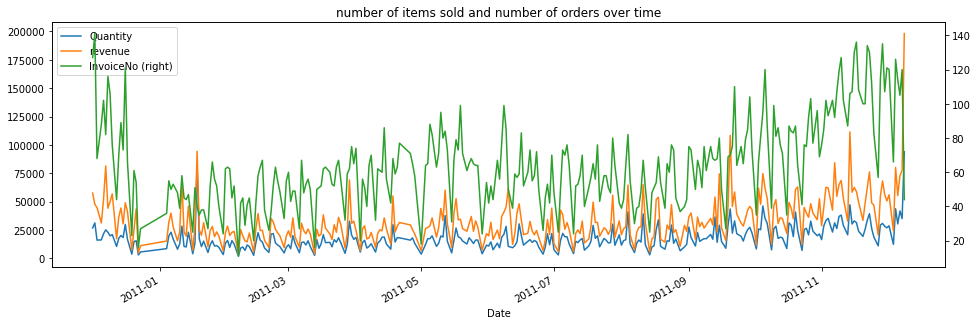

In [8]:
df.groupby('Date').agg({'Quantity': 'sum', 'revenue': 'sum', 'InvoiceNo': 'nunique'}).plot(
    title='number of items sold and number of orders over time', 
    secondary_y='InvoiceNo',
    figsize=(16, 5)
)

In [9]:
# 剔除异常偏差值
df = (
    df.assign(dNormalPrice=lambda d: d.UnitPrice / d.groupby('StockCode').UnitPrice.transform('median') 
    ).pipe(lambda d: d[(d['dNormalPrice'] > 1./3) &(d['dNormalPrice'] < 3.)]
    ).drop(columns=['dNormalPrice'])
)

In [10]:
df = df.groupby(['Date', 'StockCode', 'Country'], as_index=False).agg({
    'Description': 'first',
    'Quantity': 'sum', 
    'revenue': 'sum'
})
df['Description'] = df.groupby('StockCode').Description.transform('first')
df['UnitPrice'] = df['revenue'] / df['Quantity']

In [11]:
# 清洗完毕，数据保存为parquet
df.to_parquet('ecom_sample_clean.parquet')

## 2. 建立模型

In [12]:
# 读取数据
df = pd.read_parquet('ecom_sample_clean.parquet')

In [13]:
df.set_index(['Date', 'StockCode', 'Country']).sample(5)

,,,Description,Quantity,revenue,UnitPrice
Date,StockCode,Country,,,,
2011-12-08,21929,United Kingdom,JUMBO BAG PINK VINTAGE PAISLEY,16,39.43,2.464375
2011-07-20,85032B,United Kingdom,BLOSSOM IMAGES GIFT WRAP SET,1,0.65,0.650000
2011-06-07,20979,United Kingdom,36 PENCILS TUBE RED RETROSPOT,1,2.46,2.460000
2011-07-26,22196,United Kingdom,SMALL HEART MEASURING SPOONS,1,1.63,1.630000
2011-11-13,48184,United Kingdom,DOORMAT ENGLISH ROSE,4,33.00,8.250000


In [14]:
df_mdl = df[(df.groupby('StockCode').UnitPrice.transform('std') > 0)]
del df

In [15]:
# 将单价和数量取log
df_mdl = df_mdl.assign(
    LnP = np.log(df_mdl['UnitPrice']),
    LnQ = np.log(df_mdl['Quantity']),
)

In [16]:
df_mdl.head()

,Date,StockCode,Country,Description,Quantity,revenue,UnitPrice,LnP,LnQ
0,2010-12-01,10002,France,INFLATABLE POLITICAL GLOBE,48,40.80,0.85,-0.162519,3.871201
1,2010-12-01,10002,United Kingdom,INFLATABLE POLITICAL GLOBE,12,10.20,0.85,-0.162519,2.484907
2,2010-12-01,10125,United Kingdom,MINI FUNKY DESIGN TAPES,2,1.70,0.85,-0.162519,0.693147
3,2010-12-01,10133,United Kingdom,COLOURING PENCILS BROWN TUBE,5,4.25,0.85,-0.162519,1.609438
4,2010-12-01,10135,United Kingdom,COLOURING PENCILS BROWN TUBE,1,2.51,2.51,0.920283,0.000000


### 2.1 先查看 lnQ 和 lnP 相关关系

先来查看下相关性和因果关系的区别，这里先通过简单计算下 lnQ 和 lnP 的相关系数

#### 2.1.1 方法一：通过计算方差得到相关系数
      =cov(lnP,lnQ)/var(lnP)，得到 $\theta =\frac{-0.52}{0.90}=-0.6$

In [17]:
df_mdl[['LnP', 'LnQ']].cov()

,LnP,LnQ
LnP,0.904304,-0.526952
LnQ,-0.526952,1.816843


#### 2.1.2 方法二：通过回归计算得到 LnP 回归系数 =-0.6064

In [18]:
import statsmodels.api as sm # get full stats on regressions

def binned_ols(df, x, y, n_bins, plot=True, plot_title='', plot_ax=None, **plt_kwargs):
    # A visual form of de-noising: bin explanatory variable first, 
    # then take means-per-bin of variable to be explaioned, then regress/plot 
    x_bin = x + '_bin'
    df[x_bin] = pd.qcut(df[x], n_bins)
    
    tmp = df.groupby(x_bin).agg({
        x: 'mean',
        y: 'mean'
    })

    if plot:
        tmp.plot(
            x=x, 
            y=y,
            figsize=(18, 6),
            title=plot_title,
            ax=plot_ax,
            **plt_kwargs
        )
    
    del df[x_bin]
    mdl = sm.OLS(tmp[y], sm.add_constant(tmp[x]))
    res = mdl.fit()
    return res

"Naive" elasticity estimated to be -0.6064298425515752


/usr/local/lib64/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    LnQ   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     50.32
Date:                Fri, 23 Jul 2021   Prob (F-statistic):           8.13e-06
Time:                        10:19:42   Log-Likelihood:                -2.4958
No. Observations:                  15   AIC:                             8.992
Df Residuals:                      13   BIC:                             10.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3614      0.102     23.071      0.000       2.140       2.583
LnP           -0.6064      0.085     -7.093      0.000      -0.791      -0.422
==============================================================================
Omnibus:                        6.769   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                3.768
Skew:                           0.710   Prob(JB):                        0.152
Kurtosis:                       5.003   Cond. No.                         2.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

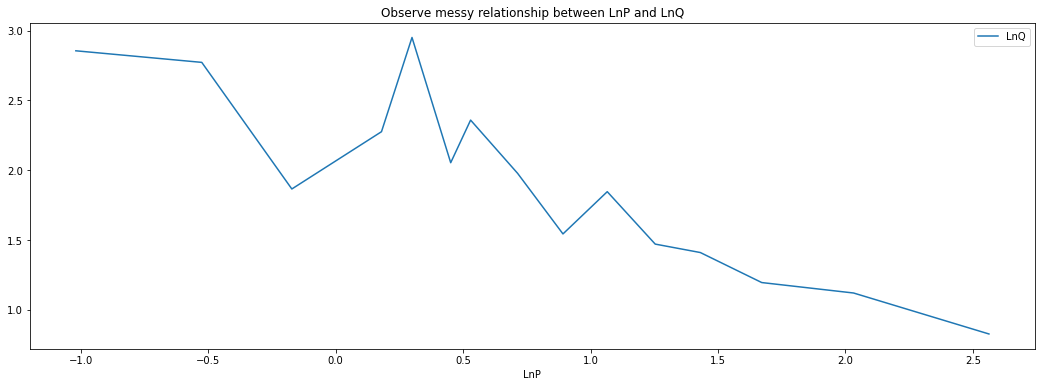

In [19]:
ols_fit = binned_ols(
    df_mdl,
    x='LnP',
    y='LnQ',
    n_bins=15,
    plot_title='Observe messy relationship between LnP and LnQ'
)

print(f'"Naive" elasticity estimated to be {ols_fit.params["LnP"]}')
ols_fit.summary()

#### 2.1.3 尝试换成柏松回归和正则化的Ridge—OLS回归方法

最终柏松回归中LnP的回归系数为 -2.87559，Ridge—OLS回归中LnP的回归系数为 -1.79945，尝试下来各个方法得到的结果差异很大。

In [20]:
import sklearn.preprocessing
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
feature_generator_basic = ColumnTransformer(
    [
        ('StockCode', OneHotEncoder(), ['StockCode']),
        ('Date', OneHotEncoder(), ['Date']),
        ('Country', OneHotEncoder(), ['Country']),
        ('LnP', 'passthrough', ['LnP']),
    ], remainder='drop'
)

mdl_basic = Pipeline([
    ('feat_proc', feature_generator_basic),
    ('reg', linear_model.PoissonRegressor(
        alpha=1e-6,  # l2 penalty strength; manually selected value for minimum interference on LnP-coef (elasticity)
        fit_intercept=False, # no need, since we have OneHot encodings without drop
        max_iter=100_000, 
    )),
], verbose=True)

mdl_basic_ols = Pipeline([
    ('feat_proc', feature_generator_basic),
    ('reg', linear_model.Ridge(
        alpha=1e-20,  # l2 penalty strength, "very small"
        fit_intercept=False, 
        max_iter=100_000, 
    )),
], verbose=True)

In [22]:
mdl_basic.fit(
    df_mdl[['LnP', 'StockCode', 'Date', 'Country']], 
    df_mdl['Quantity'] # Poisson regression has log-link, so LnQ is implicit in loss function
)

[Pipeline] ......... (step 1 of 2) Processing feat_proc, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing reg, total= 1.7min


Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('StockCode', OneHotEncoder(),
                                                  ['StockCode']),
                                                 ('Date', OneHotEncoder(),
                                                  ['Date']),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('LnP', 'passthrough',
                                                  ['LnP'])])),
                ('reg',
                 PoissonRegressor(alpha=1e-06, fit_intercept=False,
                                  max_iter=100000))],
         verbose=True)

In [23]:
mdl_basic_ols.fit(
    df_mdl[['LnP', 'StockCode', 'Date', 'Country']], 
    df_mdl['LnQ'] # log-normal
)

[Pipeline] ......... (step 1 of 2) Processing feat_proc, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.1s


Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('StockCode', OneHotEncoder(),
                                                  ['StockCode']),
                                                 ('Date', OneHotEncoder(),
                                                  ['Date']),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('LnP', 'passthrough',
                                                  ['LnP'])])),
                ('reg',
                 Ridge(alpha=1e-20, fit_intercept=False, max_iter=100000))],
         verbose=True)

In [24]:
print('"Econometrically" estimated elasticity with unit-, time-, and market- controls, using Poisson loss (coef on LnP):')
pd.DataFrame({
    'feat': mdl_basic['feat_proc'].get_feature_names(),
    'coef': mdl_basic['reg'].coef_
}).iloc[-1]

"Econometrically" estimated elasticity with unit-, time-, and market- controls, using Poisson loss (coef on LnP):


feat      LnP
coef   -2.978
Name: 3708, dtype: object

In [25]:
print('"Econometrically" estimated elasticity with unit-, time-, and market- controls, using log-Normal loss (coef on LnP):')
pd.DataFrame({
    'feat': mdl_basic_ols['feat_proc'].get_feature_names(),
    'coef': mdl_basic_ols['reg'].coef_
}).iloc[-1]

"Econometrically" estimated elasticity with unit-, time-, and market- controls, using log-Normal loss (coef on LnP):


feat       LnP
coef   -1.7711
Name: 3708, dtype: object

### 2.2 接下来算需求量 Q 对价格 P 的弹性关系

这里采用 DML（Double Machine Learning） 方法进行因果推断，该方法主要解决两个问题，第一，通过正则化挑拣重要控制变量；第二，对比传统的线性回归模型，用非参数推断可以解决非线性问题。

1. 将数据分为两部分，一部分样本选用随机森林等模型，用混杂变量预测处理变量（价格 P），得到 E[P|X]；另外的样本同样可选择随机森林模型，用混杂变量预测结果变量（需求量 Q），得到 E[Q|X]。

2. 计算残差，得到不受混杂变量影响的价格 P 和 需求量 Q，即为 $\widetilde P , \widetilde Q$

$$\widetilde P = P-E[P|X]$$
$$\widetilde Q = Q-E[Q|X]$$

3. 因此直接将$\widetilde P , \widetilde Q$ 进行 log-log 回归就能得到弹性系数 $𝜃$

$$需要得到 \theta=\frac{d_\widetilde Q/\widetilde Q}{d_\widetilde P/\widetilde P}$$

$$倒推用log-log回归得到回归系数，即log \widetilde Q ～ \theta * log \widetilde P+ 截距$$

#### 2.2.1 第一步先去均值化

因为不同产品的单价差异很大，所以对于同一维度的单价需要减去该维度的单价均值 $dLnP_{i,t}=log(p_{i,t})-log(\overline p_{i})$，进一步计算得到 $\theta=\frac{-0.122}{0.07}=-1.7$

In [26]:
df_mdl['dLnP'] = np.log(df_mdl.UnitPrice) - np.log(df_mdl.groupby('StockCode').UnitPrice.transform('mean'))
df_mdl['dLnQ'] = np.log(df_mdl.Quantity) - np.log(df_mdl.groupby('StockCode').Quantity.transform('mean'))

In [27]:
df_mdl[['dLnP', 'dLnQ']].cov()

,dLnP,dLnQ
dLnP,0.069442,-0.122753
dLnQ,-0.122753,1.279834


#### 2.2.2 第二步计算衍生特征

1. 季节性变量：该价格处于第几月、处于月里第几天和周里第几天
2. 产品上线的时长：用当期时间减去该产品的最小时间
3. sku 的价格水平：单个sku内的价格中位数

In [28]:
df_mdl = df_mdl.assign(
    month = lambda d: d.Date.dt.month,
    DoM =   lambda d: d.Date.dt.day,
    DoW =   lambda d: d.Date.dt.weekday,
    stock_age_days = lambda d: (d.Date - d.groupby('StockCode').Date.transform('min')).dt.days,
    sku_avg_p = lambda d: d.groupby('StockCode').UnitPrice.transform('median')
)

#### 2.2.3 用混杂变量预测价格 P 和需求量 Q

2.2.3.1 这里用随机森林模型进行预测，预测前需要对维度变量进行独热编码，对度量特征进行归一化

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
feature_generator_full = ColumnTransformer(
    [
        # do NOT include to reduce overfit (price is sku-level-demeaned anyway): 
        # ('StockCode', OneHotEncoder(), ['StockCode']), 
        ('Date', OneHotEncoder(), ['Date']),
        ('Description', CountVectorizer(min_df=0.0025, ngram_range=(1, 3)), 'Description'),
        ('Country', OneHotEncoder(), ['Country']),
        ('numeric_feats', StandardScaler(), ['month', 'DoM', 'DoW', 'stock_age_days', 'sku_avg_p']),
    ], remainder='drop'
)

In [31]:
model_y = Pipeline([
    ('feat_proc', feature_generator_full),
    ('model_y', RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1, verbose=0)) 
    # n_samples_leaf/n_estimators is set to reduce model (file) size and runtime
    # larger models yield prettier plots.
])
model_t = Pipeline([
    ('feat_proc', feature_generator_full),
    ('model_t', RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1, verbose=0))
])

In [32]:
import joblib

try: # load existing models, if possible
    model_y = joblib.load('models/step1_model_y.joblib')
    model_t = joblib.load('models/step1_model_t.joblib')
except:
    print('No pre-existing models found, fitting aux models for y and t')
    model_y.fit(df_mdl, df_mdl.dLnQ)
    model_t.fit(df_mdl, df_mdl.dLnP)
    
    joblib.dump(model_y, 'models/step1_model_y.joblib', compress=True)
    joblib.dump(model_t, 'models/step1_model_t.joblib', compress=True)

In [33]:
# Get first-step, predictions to residualize ("orthogonalize") with (in-sample for now)
q_hat = model_y.predict(df_mdl)
p_hat = model_t.predict(df_mdl)

2.2.3.2 用观测值减去预测得到的值求解残差

In [34]:
df_mdl = df_mdl.assign(
    dLnP_res = df_mdl['dLnP'] - p_hat,
    dLnQ_res = df_mdl['dLnQ'] - q_hat,
)

2.2.3.3 用残差拟合OLS回归模型得到回归系数为 -1.819，和之前去均值化后的ols模型结果 -1.7 比较，二者的斜率还是有一定的差异

"Average" elasticity estimated using DML (now supposedly valid estimate!) to be -1.820
Note that this is close to our econometric contols - some difference comes from the different distribution assumptions (Poisson vs. log-normal)


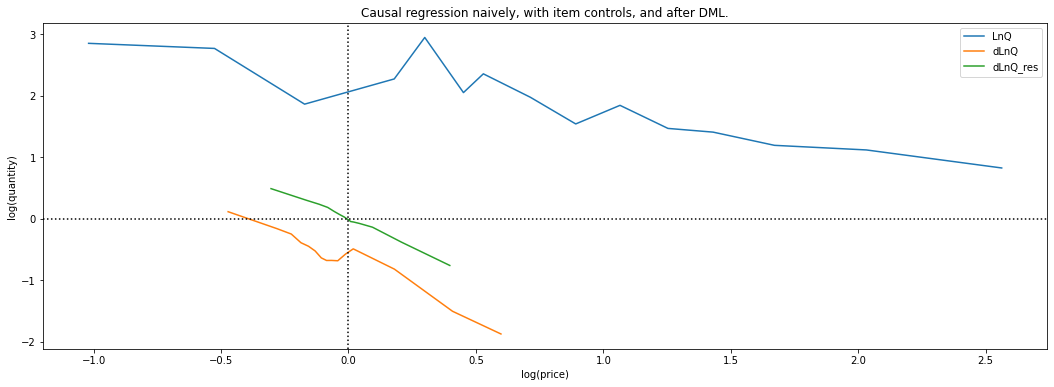

In [35]:
# 初始ols模型
old_fit = binned_ols(
    df_mdl,
    x='LnP',
    y='LnQ',
    n_bins=15,
)
# 初始去均值化后的ols模型
old_fit = binned_ols(
    df_mdl,
    x='dLnP',
    y='dLnQ',
    n_bins=15,
    plot_ax=plt.gca(),
)
# 残差拟合的ols模型
old_fit = binned_ols(
    df_mdl,
    x='dLnP_res',
    y='dLnQ_res',
    n_bins=15,
    plot_title='Causal regression naively, with item controls, and after DML.',
    plot_ax=plt.gca()
)
plt.gca().set(
    xlabel='log(price)',
    ylabel='log(quantity)',    
)

plt.gca().axvline(0, color='k', linestyle=':')
plt.gca().axhline(0, color='k', linestyle=':')


print(
    f'"Average" elasticity estimated using DML (now supposedly valid estimate!) to be {old_fit.params["dLnP_res"]:.3f}\n'
    'Note that this is close to our econometric contols - some difference comes from the different distribution '
    'assumptions (Poisson vs. log-normal)'
)

In [36]:
def get_feat_generator_names(gen):
    # workaround to sklearn native .get_feature_names() failing
    # because StandardScaler strangely doesn't implement it
    res = []
    for i, (k, t) in enumerate(gen.named_transformers_.items()):
        if k == 'remainder':
            continue
        try: 
            res += [f'{k}_{n}' for n in t.get_feature_names()]
        except:
            res += list(gen.transformers_[i][2])
    return res

<AxesSubplot:title={'center':'feature importances for DML estimators of treatment(p) and outcome(q)'}, ylabel='feat'>

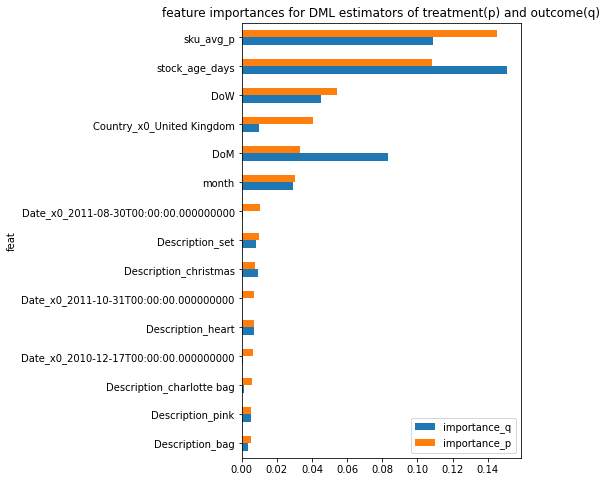

In [37]:
feat_imp = pd.DataFrame({
    'feat': get_feat_generator_names(model_y['feat_proc']),
    'importance_q': model_y['model_y'].feature_importances_,
    'importance_p': model_t['model_t'].feature_importances_,
}).set_index('feat')

feat_imp.sort_values(by='importance_p').iloc[-15:].plot.barh(
    figsize=(5, 8), 
    title='feature importances for DML estimators of treatment(p) and outcome(q)'
)

#### 2.2.4 K-Fold 稳健性结果

模型的预测推断结果是 $\hat \theta=\frac{dLnQ_{res}}{dLnP_{res}}$，但是残差正交化后，$dLnP_{res}$ 总是很小，因此为了减少噪音，我们将丢弃所有非常小的价格变化观察值，它们不包含太多信息。Chernozhukov 提出了一个改进的 DML，传统的标准 OLS 方法估计$\hat \theta=(\widetilde P^T  \widetilde P)^{-1}\widetilde P^T \widetilde Q$，但改进的 
$\hat \theta=(\widetilde P^T P)^{-1}\widetilde P^T \widetilde Q^T$，即第二个 P 矩阵用未残差化的。

最后采取 2-fold 得到平均值使得结果更稳健，最终弹性系数结果为 -1.89

In [38]:
from sklearn.model_selection import KFold

fitting model_y
fitting model_t
DML elast:  -1.895475650066915
OLS elasticity for comparison: -1.8343484758337214
fitting model_y
fitting model_t
DML elast:  -1.8848008445530626
OLS elasticity for comparison: -1.8369864792500255
DML efficient estimate of elasticity: -1.8901382473099888


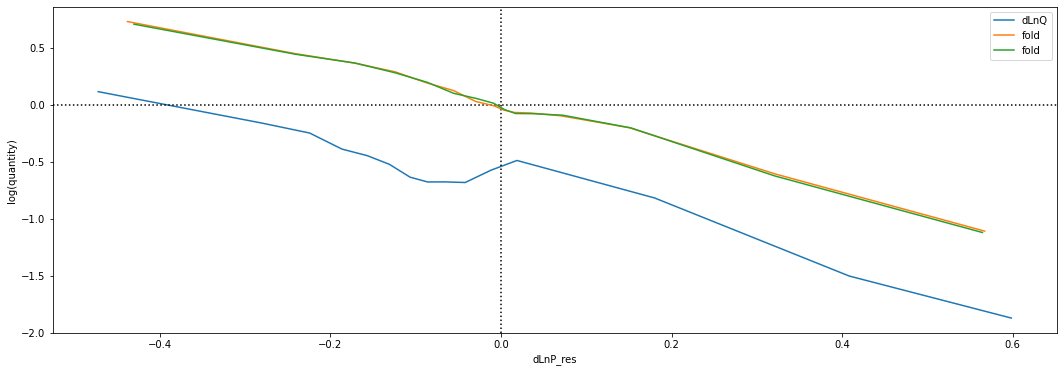

In [39]:
old_fit = binned_ols(
    df_mdl,
    x='dLnP',
    y='dLnQ',
    n_bins=15,
    plot_ax=plt.gca(),
)
plt.gca().set(
    xlabel='log(price)',
    ylabel='log(quantity)',    
)
plt.gca().axvline(0, color='k', linestyle=':')
plt.gca().axhline(0, color='k', linestyle=':')


elast_estimates = list()
for idx_aux, idx_inf in KFold(n_splits=2, shuffle=True).split(df_mdl):
    
    df_aux = df_mdl.iloc[idx_aux]
    df_inf = df_mdl.iloc[idx_inf].copy()
    
    # step 1: aux models and residualize in inferential set
    print('fitting model_y')
    model_y.fit(df_aux, df_aux.dLnQ)
    print('fitting model_t')
    model_t.fit(df_aux, df_aux.dLnP)
    
    df_inf = df_inf.assign(
        dLnP_res = df_inf['dLnP'] - model_t.predict(df_inf),
        dLnQ_res = df_inf['dLnQ'] - model_y.predict(df_inf),
    )
    
    binned_ols(
        df_inf,
        x='dLnP_res',
        y='dLnQ_res',
        n_bins=15,
        plot_ax=plt.gca(),
        label='fold'
    )
    
    # ignore observations where we residualized away all variation in price
    mask = (~(df_inf.dLnP_res.abs() < 0.01))
    df_inf_censored = df_inf[mask]
    
    # step 2.1: Chernozhukov DML inference
    elast = (
        df_inf_censored['dLnP_res'].dot(df_inf_censored['dLnQ_res'])
        /
        df_inf_censored['dLnP_res'].dot(df_inf_censored['dLnP'])
        # the last part here deviates from standard OLS solution
    )
    
    print('DML elast: ', elast)
    elast_estimates.append(elast)

    print('OLS elasticity for comparison:',
        df_inf_censored['dLnP_res'].dot(df_inf_censored['dLnQ_res'])
        /
        df_inf_censored['dLnP_res'].dot(df_inf_censored['dLnP_res'])
    )    

print("DML efficient estimate of elasticity:", np.mean(elast_estimates))